# MAST30034 Applied Data Science - Generic Buy Now, Pay Later Project

## Group 5 - Project Summary

## 1. ETL Process

Within the first three weeks of the project, we were provided with the following data:
- Merchant information
- Consumer information
- User to Consumer ID mapping table
- Transaction information
- Merchant's fraud probability
- Consumer's fraud probability

Further, we downloaded the following external datasets:
- 2021 Australia census data
- Postcode to Statistical Area 2 (SA2) code mapping table
- SA2 boundaries shapefile

From the census data, the following features (which were categorised by SA2) were shortlisted:
- Population
- Median of weekly personal income
- Median of mortgage repayment
- Median age of residents
- Average household size
- Education level

The provided data were appropriately joined with the census data by SA2 code to create a table with all information compiled in a single table. 

## 2. Outlier Analysis

After joining the datasets, there were 750332 null values in the SA2 dataset and 182 in the origninal dataset, these comprised of approximatley 2% of the total dataset. for null values in the SA2 dataset, the postcodes were used to determine which state the purchase came from. then averaging over all the data in that state the other columns were populated.

In [ ]:
# Import libraries
from pyspark.sql import SparkSession, functions as F, DataFrame
from pyspark.sql.functions import isnan, when, count, col

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from turtle import title

import geopandas as gpd
import folium

# Create spark session
spark = (
    SparkSession.builder.appName("Summary")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

# Read in preprocessed data
data = spark.read.parquet('../data/curated/final_data.parquet')
sf = gpd.read_file("../data/external/shapefile/SA2_2021_AUST_GDA2020.shp")
external_data = pd.read_parquet('../data/curated/external_data.parquet')
data_pd = pd.read_parquet('../data/curated/final_data.parquet')

### Customer Details
- **SA2_CODE_2021 / SA2_NAME_2021**: For null values in the SA2 dataset, the postcodes were used to determine which state the purchase came from. then averaging over all the data in that state the other columns were populated (see `null_imputation.py`).

- **Postcode**: Remove all instances in a null postcode as there is not way to determine the location of the purchase with the postcode. According to AusPost, all post between 1000-9999 are valid, thus we will keep all.

-  **Gender**: No outliers found.

In [ ]:
# Drop null postcodes
data = data.na.drop(subset=["postcode"])

# Confirm postcode range
print(data.agg({'postcode': 'min'}))
print(data.agg({'postcode': 'max'}))

# Check for outlier in gender
data.groupBy('gender').count()

### Order Details

-  **Order Date**: Based on the output all values are in 2021-2022. 
    - The latest snapshot was obtained on 2022-08-28, but contains orders placed after the date, which is illogical, thus we will remove orders with order date after this date
    


- **ABN**: All ABNs are 11 digits long, thus we will verify this.

- **Dollar Value**:
    - Instances < $0.05 seem unreasonable due the the limited things you can buy for 5c, thus they will be removed from the dataset.

    - Instances > $50,000 come from anitque shops or jewelry shops and thus is plausible for the individuals to be spending large amounts of money.

In [ ]:
# Drop invalid orders
data = data.where(col('order_datetime') <= '2022-08-28')

In [ ]:
# Confirm order date range
print(data.agg({'order_datetime': 'min'}))
print(data.agg({'order_datetime': 'max'}))

# Check ABN range
print(data.agg({'merchant_abn': 'min'}))
print(data.agg({'merchant_abn': 'max'}))

# Check dollar value range
print(data.agg({'dollar_value': 'min'}))
print(data.agg({'dollar_value': 'max'}))

In [ ]:
# Number of orders < $0.05
data.where(col("dollar_value") <= 0.05).count()

In [ ]:
# Remove instances < $0.05
data  = data.where(col('dollar_value') >= 0.05)

In [ ]:
# Check instances > $50000
data.where(col("dollar_value") >= 50000).limit(10)

## 3. Exploratory Data Analysis

### Transaction Analysis

#### Transaction Location

From our analysis, we found that New South Wales and Victoria have the highest total transaction volume and amount. Yet, transations in Australian Capital Territory have the highest average transaction amount, which could be related to the higher average income level of the territory.

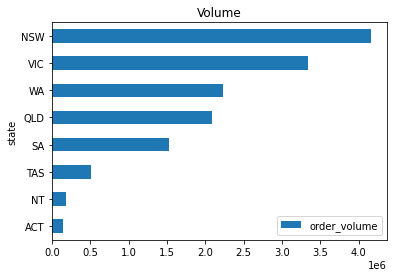
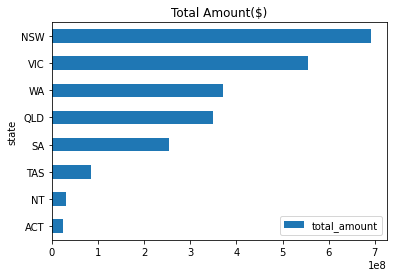
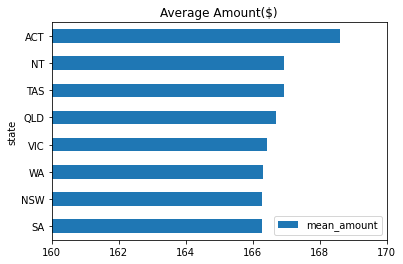

#### Transaction Datetime

Throughout the year (based on data from 2021), the daily average transaction amount saw an even distribution. The average transaction amount is also evenly distributed throughout the days of the week.
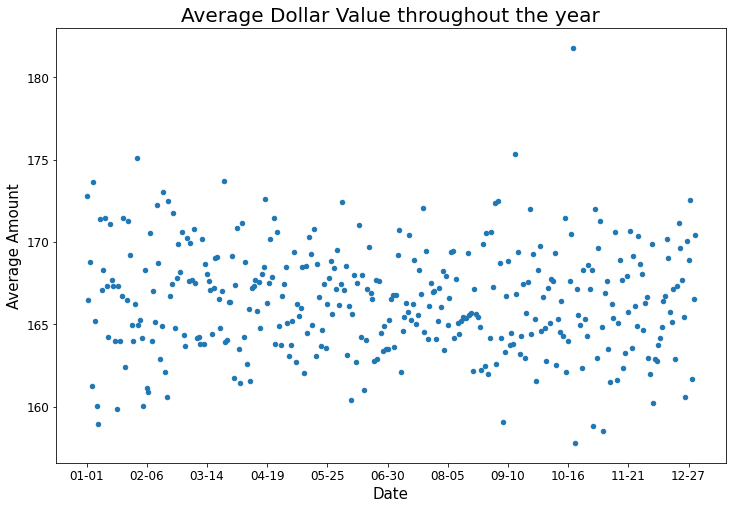
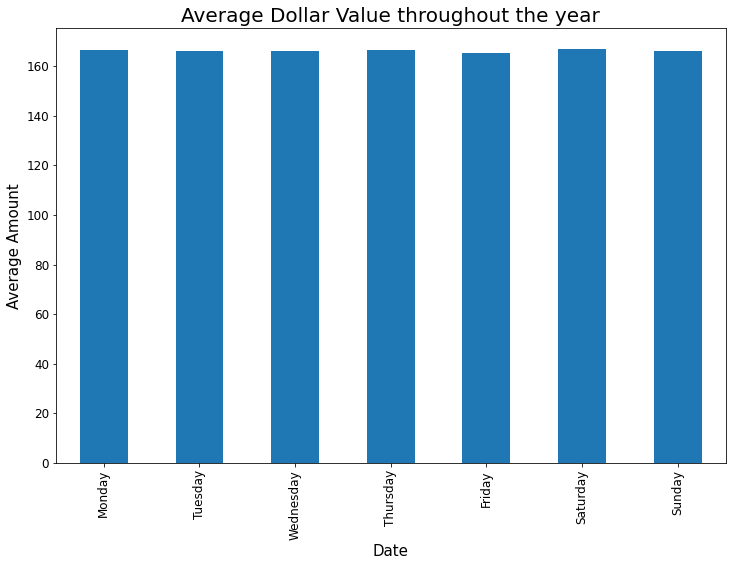

The overall distribution of transaction amount follows a log-normal distribution, with most of the transaction dollar value lying between \\$0 - \\$250. 
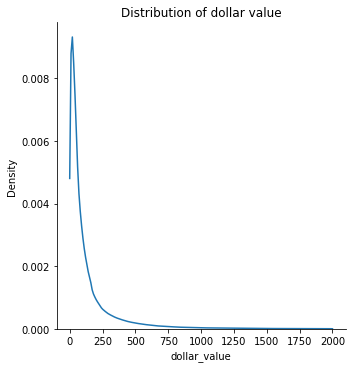

Merchants are categorised into five different revenue levels according to their revenue bands, with 'a' denoting the lowest band and 'e' denoting the highest band. Most of the merchants fall in the low to moderate revenue bands.
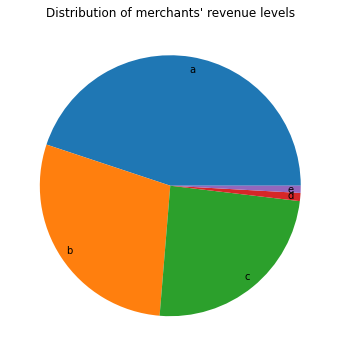

## 4. Feature Modelling

## 5. Ranking System 